<a href="https://colab.research.google.com/github/gyselle-marques/TransferLearning-DesafioDIO/blob/main/rede_neural_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [ ]:
transform = transforms.ToTensor() #define a conversão de imagem para tensor
trainset = datasets.MNIST('./MNIST_data/', download=True, train=True, transform=transform) #carrega parte do treino do dataset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True) #cria um buffer para pegar os dados por partes

valset = datasets.MNIST('./MNIST_data/', download=True, train=True, transform=transform) #carrega a parte de validação do dataset
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True) #cria um biffer para pegar os dados por partes

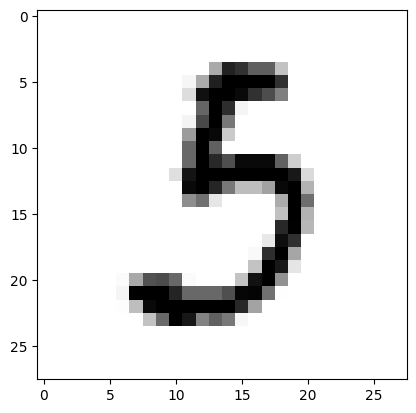

In [ ]:
dataiter = iter(trainloader)
imagens, etiquetas = next(dataiter)
plt.imshow(imagens[0].numpy().squeeze(), cmap='gray_r');

In [ ]:
print(imagens[0].shape) #verifica as dimensões do tensor de cada imagem
print(etiquetas[0].shape) #verifica as dimensões do tensor de cada etiqueta

torch.Size([1, 28, 28])
torch.Size([])


In [ ]:
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.linear1 = nn.Linear(28*28, 128) # camada de entrada, 784 neurônios que se ligam a 128
        self.linear2 = nn.Linear(128, 64) # camada interna 1, 128 neurônios que se ligam a 64
        self.linear3 = nn.Linear(64, 10) # camada interna 2, 64 neurônios que se ligam a 10
        #para a camada de saída não é necessário definir nada pois só precisamos pegar o output da camada interna 2

        def forward(self, X):
            X = F.relu(self.linear1(X)) #função de ativação da camada de entrada para a camada interna 1
            X = F.relu(self.linear2(X)) #função de ativação da camada interna 1 para a camada interna 2
            X = self.linear3(X) #função de ativação da camada interna 2 para a camada de saída, nesse caso f(x) = x
            return F.log_softmax(X, dim=1) #dados utilizados para calcular a perda

In [ ]:
def treino(modelo, trainloader, device):

  otimizador = optim.SGD(modelo.parameters(), lr=0.01, momentum=0.5) #define a política de atualização dos pesos e da bias
  inicio = time() #timer para sabermos quanto tempo levou o treino

  criterio = nn.NLLLoss() #define o critério para calcular a perda
  EPOCHS = 10 #define o número de épocas // númério de epochs que o algoritmo rodará
  modelo.train() #ativa o modo de treinamento do modelo

  for epoch in range(EPOCHS):
    perda_acumulada = 0 #inicia a perda acumulada da época/epoch em 0

    for imagens, etiquetas in trainloader:
      imagens = imagens.view(imagens.shape[0], -1) #converte as imagens para "vetores" de 28*28 casas para ficarem compatíveis com a...
      otimizador.zero_grad() #zera os gradientes por conta do ciclo anterior

      output = modelo(imagens.to(device)) #coloca os dados no modelo
      perda_instantanea = criterio(output, etiquetas.to(device)) #calcula a perda da epoch em questão

      perda_instantanea.backward() #back propagation a partir da perda

      otimizador.step() #atualiza os pesos e a bias

      perda_acumulada += perda_instantanea.item() #atualização da perda acumulada

    else:
      print("Epoch {} - Perda resultante: {}".format(epoch+1, perda_acumulada/len(trainloader)))
      print("\nTempo de treino (em minutos) = ",(time()-inicio)/60)


In [ ]:
def validacao(modelo, valloader, device):
  conta_corretas, conta_todas = 0, 0
  for imagens,etiquetas in valloader:
    for i in range(len(etiquetas)):
      img = imagens[i].view(1, 784)
      # desativa o autograd para acelerar a validação (grafos computacionais dinâmicos possuem custo alto de processamento)
      with torch.no_grad():
        logps = modelo(img.to(device)) #output do modelo em escala logarítmica

        ps = torch.exp(logps) #converte o output para escala linear/normal (lembrando que é um tensor)
        probab = list(ps.cpu().numpy()[0])
        etiqueta_pred = probab.index(max(probab)) #converte o tensor em um número, no caso, o número que o modelo previu como correto
        etiqueta_certa = etiquetas.numpy()[i]
        if(etiqueta_certa == etiqueta_pred): #compara a previsão com o valor correto
          conta_corretas += 1
        conta_todas += 1

  print("Total de imagens testadas = ", conta_todas)
  print("\nPrecisão do modelo = {}%".format(conta_corretas*100/conta_todas))

In [ ]:
modelo = Modelo() #inicializa o modelo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #modelo rodará na GPU se possível
modelo.to(device)

Modelo(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)